In [2]:
import scanpy as sc
import seaborn as sns
import os 
from matplotlib import rcParams
import matplotlib.pyplot as plt

import argparse
import functools
import pathlib
import warnings
from itertools import compress

import anndata
import numpy as np
import pandas as pd
import yaml

In [3]:
from typing import Tuple

import numpy as np
import pandas as pd
import scanpy as sc
import scipy.spatial
import sklearn.metrics
import sklearn.neighbors
from anndata import AnnData
from scipy.sparse.csgraph import connected_components
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

def classifer_knn(
        x: np.ndarray, y: np.ndarray, neighbor_frac: float = 0.01, test_size: float = 0.8, **kwargs
) -> float:
    k = max(round(y.shape[0] * neighbor_frac), 1)
    DATA_tr, DATA_te, tr_LABEL, te_LABEL = train_test_split(x, y, test_size=test_size, random_state=42)
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(DATA_tr, tr_LABEL)
    L_pred = clf.predict(x)
    return L_pred


In [4]:
main_type = 'ENDO'
method = [
            'GLUE', 'LIGER',
            'scMoMaT', 
            'bindsc', 'Cobolt',
            'Pamona', 'PCA', 'scJoint', 'seurat4',
            'iNMF', 'scVI',
            ]


In [5]:
input_datasets = ['/mnt/nas/user/yixuan/Multiomics-benchmark-main/data/download/Muto-2021-batch-1-small/Muto-2021-batch-1-small-RNA.h5ad']

In [6]:
datasets = [anndata.read_h5ad(item) for item in input_datasets]
cell_types = [dataset.obs["cell_type"].to_numpy() for dataset in datasets]
domains = [dataset.obs["domain"].to_numpy() for dataset in datasets]
vars = [dataset.var_names for dataset in datasets]
unis = [np.array(dataset.X.todense()) for dataset in datasets]

In [7]:
np.unique(cell_types[0])

array(['CNT', 'DCT', 'ENDO', 'ICA', 'ICB', 'LEUK', 'MES_FIB', 'PC', 'PEC',
       'PODO', 'PT', 'PT_VCAM1', 'TAL'], dtype=object)

In [8]:
marker_dict = {}

In [9]:
for item in method:
    input_latents = [f'/mnt/nas/user/yixuan/Multiomics-benchmark-main/results/Muto-2021-batch-1-small/{item}_rna.csv']
    latents = [pd.read_csv(item, header=None, index_col=0).to_numpy() for item in input_latents]
    masks = [np.apply_along_axis(lambda x: ~np.any(np.isnan(x)), 1, latent) for latent in latents]
    for i, mask in enumerate(masks):
        rm_pct = 100 * (1 - mask.sum() / mask.size)
        if rm_pct:
            print(f"Ignoring {rm_pct:.1f}% cells in dataset {i} due to missing values!")
    combined_cell_type = np.concatenate([cell_type[mask] for cell_type, mask in zip(cell_types, masks)])
    combined_domain = np.concatenate([domain[mask] for domain, mask in zip(domains, masks)])
    combined_var = np.concatenate([var for var in vars])
    combined_uni = np.concatenate([uni[mask] for uni, mask in zip(unis, masks)], axis=1)
    combined_latent = np.concatenate([latent[mask] for latent, mask in zip(latents, masks)], axis=1)
    combined_predicted_cell_type = classifer_knn(combined_latent, cell_types[0])
    adata = sc.AnnData(X=combined_uni,
                        obs=list(domains[0]),
                        var=list(combined_var))
    adata.var_names = combined_var
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(
        adata,
        n_top_genes=5000,
        flavor="seurat",
        batch_key=None,
    )
    adata = adata[:, adata.var.highly_variable]
    adata.obs['cell_type'] = np.array(cell_types[0])
    adata.obs['predicted_cell_type'] = np.array(combined_predicted_cell_type)
    sc.tl.rank_genes_groups(
        adata, 
        groupby = 'predicted_cell_type', 
        groups = [main_type],
        method = 't-test',
        n_genes = 100,
        )
    md = ( 
        sc.get.rank_genes_groups_df(adata, group=main_type) 
        .set_index('names', drop=True) 
    ) 
    marker_dict[item] = md.index
    print("Finish: ", item)



/tmp/ipykernel_31997/1969389028.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_type'] = np.array(cell_types[0])


Finish:  GLUE


/tmp/ipykernel_31997/1969389028.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_type'] = np.array(cell_types[0])


Finish:  LIGER


/tmp/ipykernel_31997/1969389028.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_type'] = np.array(cell_types[0])


Finish:  scMoMaT


/tmp/ipykernel_31997/1969389028.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_type'] = np.array(cell_types[0])


Finish:  bindsc


/tmp/ipykernel_31997/1969389028.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_type'] = np.array(cell_types[0])


Finish:  Cobolt


/tmp/ipykernel_31997/1969389028.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_type'] = np.array(cell_types[0])


Finish:  Pamona


/tmp/ipykernel_31997/1969389028.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_type'] = np.array(cell_types[0])


Finish:  PCA


/tmp/ipykernel_31997/1969389028.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_type'] = np.array(cell_types[0])


Finish:  scJoint


/tmp/ipykernel_31997/1969389028.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_type'] = np.array(cell_types[0])


Finish:  seurat4


/tmp/ipykernel_31997/1969389028.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_type'] = np.array(cell_types[0])


Finish:  iNMF


/tmp/ipykernel_31997/1969389028.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_type'] = np.array(cell_types[0])


Finish:  scVI


In [14]:
# def jaccard(first, second):
#     return len(set(first).intersection(second)) / len(set(first).union(second))
def jaccard(first, second):
    print(type(first))    
    # Check and convert first input
    if isinstance(first, set):
        first_set = first
    elif isinstance(first, pd.Index):
        first_set = set(first) if not first.empty else set()
    else:
        first_set = set()

    # Check and convert second input
    if isinstance(second, set):
        second_set = second
    elif isinstance(second, pd.Index):
        second_set = set(second) if not second.empty else set()
    else:
        second_set = set()
    # Check if both indices are empty
    if not first_set and not second_set:
        print('**')
        # Handle the case where both sets are empty
        # Return 1 or 0 based on your convention for similarity of empty sets
        return 1.0
    print('##')
    return len(first_set.intersection(second_set)) / len(first_set.union(second_set))

In [15]:
keys = list(marker_dict.keys())
result_dict = {}
len(keys)

11

In [16]:
for k in keys:
    for l in keys:
        result_dict[(k,l)] = marker_dict.get((l,k), jaccard(marker_dict[k], marker_dict[l]))

<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base.Index'>
##
<class 'pandas.core.indexes.base

In [13]:
result_dict

{('GLUE', 'GLUE'): 1.0,
 ('GLUE', 'LIGER'): 0.6666666666666666,
 ('GLUE', 'scMoMaT'): 0.639344262295082,
 ('GLUE', 'bindsc'): 0.7543859649122807,
 ('GLUE', 'Cobolt'): 0.6260162601626016,
 ('GLUE', 'Pamona'): 0.639344262295082,
 ('GLUE', 'PCA'): 0.680672268907563,
 ('GLUE', 'scJoint'): 0.6528925619834711,
 ('GLUE', 'seurat4'): 0.6260162601626016,
 ('GLUE', 'iNMF'): 0.7094017094017094,
 ('GLUE', 'scVI'): 0.7094017094017094,
 ('LIGER', 'GLUE'): 0.6666666666666666,
 ('LIGER', 'LIGER'): 1.0,
 ('LIGER', 'scMoMaT'): 0.7857142857142857,
 ('LIGER', 'bindsc'): 0.8518518518518519,
 ('LIGER', 'Cobolt'): 0.7094017094017094,
 ('LIGER', 'Pamona'): 0.5748031496062992,
 ('LIGER', 'PCA'): 0.7543859649122807,
 ('LIGER', 'scJoint'): 0.6528925619834711,
 ('LIGER', 'seurat4'): 0.7094017094017094,
 ('LIGER', 'iNMF'): 0.7543859649122807,
 ('LIGER', 'scVI'): 0.6260162601626016,
 ('scMoMaT', 'GLUE'): 0.639344262295082,
 ('scMoMaT', 'LIGER'): 0.7857142857142857,
 ('scMoMaT', 'scMoMaT'): 1.0,
 ('scMoMaT', 'bindsc

In [12]:
data = np.array(list(result_dict.values()) ).reshape(len(keys),len(keys))

In [15]:
data

array([[1.        , 0.66666667, 0.63934426, 0.75438596, 0.62601626,
        0.63934426, 0.68067227, 0.65289256, 0.62601626, 0.70940171,
        0.70940171],
       [0.66666667, 1.        , 0.78571429, 0.85185185, 0.70940171,
        0.57480315, 0.75438596, 0.65289256, 0.70940171, 0.75438596,
        0.62601626],
       [0.63934426, 0.78571429, 1.        , 0.7699115 , 0.68067227,
        0.5503876 , 0.75438596, 0.68067227, 0.83486239, 0.73913043,
        0.65289256],
       [0.75438596, 0.85185185, 0.7699115 , 1.        , 0.69491525,
        0.6       , 0.81818182, 0.72413793, 0.72413793, 0.75438596,
        0.69491525],
       [0.62601626, 0.70940171, 0.68067227, 0.69491525, 1.        ,
        0.61290323, 0.75438596, 0.72413793, 0.58730159, 0.69491525,
        0.61290323],
       [0.63934426, 0.57480315, 0.5503876 , 0.6       , 0.61290323,
        1.        , 0.61290323, 0.62601626, 0.51515152, 0.63934426,
        0.6       ],
       [0.68067227, 0.75438596, 0.75438596, 0.81818182, 0.

In [13]:
methods = keys

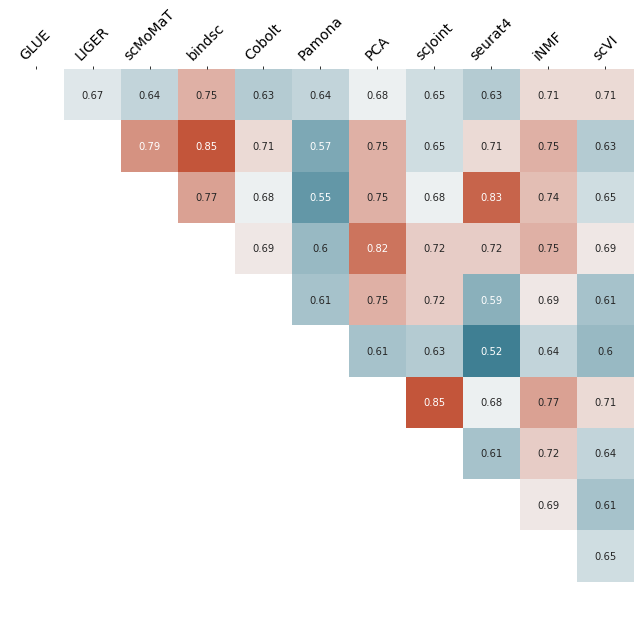

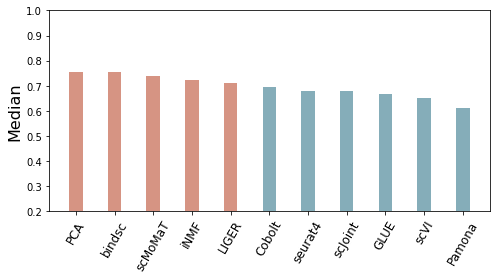

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' and 'keys' variables are already defined
mask = np.tril(np.ones_like(data, dtype=bool))
medians = np.median(data, axis=1)  # Calculate medians

# Sorting medians and keys from high to low
sorted_indices = np.argsort(medians)[::-1]
sorted_medians = medians[sorted_indices]
sorted_keys = np.array(keys)[sorted_indices]

# Plotting the heatmap separately
fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(data, mask=mask, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax, cbar=False)
ax.set_xticklabels(keys, rotation=45, fontsize=14)
ax.set_yticks([]) 
ax.xaxis.tick_top()
plt.tight_layout()
plt.savefig(f'/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/graphs/{main_type}_heatmap.pdf', transparent=True)

# Plotting the sorted histogram separately with color coding
fig, ax = plt.subplots(figsize=(7, 4))
bar_width = 0.35
x = np.arange(len(sorted_keys))

# Color coding based on intervals
for i, median in enumerate(sorted_medians):
    color = sns.diverging_palette(220, 20)[4] if median >= 0.7 else (sns.diverging_palette(220, 20)[1] if median >= 0.6 else sns.diverging_palette(220, 20)[0])
    ax.bar(i, median, width=bar_width, color=color)

ax.set_xticks(x)
ax.set_xticklabels(sorted_keys, rotation=60, fontsize=12)
ax.set_ylim(0.2, 1)
ax.set_ylabel('Median', fontsize=16)  # Label changed to 'Median'
plt.tight_layout()
plt.savefig(f'/mnt/nas/user/yixuan/Multiomics-benchmark-main/evaluation/workflow/scripts/graphs/{main_type}_histogram.pdf', transparent=True)
